# Determining Sentence Sentiment using NLP

In [ ]:
import torch
import pandas as pd
import os
import itertools

# My libraries
from src import Trainer, Plotter, DynamicRNN
from src import get_sst_data_loaders

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running experiments on hardware type: {DEVICE}")

Running experiments on hardware type: cuda


In [ ]:
BATCH_SIZE = 64
EMBEDDING_DIM = 300
HIDDEN_DIM = 256
OUTPUT_DIM = 5
DROPOUT = 0.5
EPOCHS = 15
LEARNING_RATE = 0.001

VECTOR_PATH = "./data/vector.txt"

TRAINED_WEIGHTS_DIR = "./trained_weights"
if not os.path.exists(TRAINED_WEIGHTS_DIR):
    os.makedirs(TRAINED_WEIGHTS_DIR)

CSV_DIR = "./csv_logs"
if not os.path.exists(CSV_DIR):
    os.makedirs(CSV_DIR)

In [ ]:
print("Initializing Data Pipeline...")

train_iter, val_iter, test_iter, TEXT_FIELD, LABEL_FIELD = get_sst_data_loaders(
    batch_size=BATCH_SIZE, vector_path=VECTOR_PATH, device=DEVICE
)

VOCAB_SIZE = len(TEXT_FIELD.vocab)
PAD_IDX = TEXT_FIELD.vocab.stoi.get(TEXT_FIELD.vocab.pad_token)
PRETRAINED_VECTORS = TEXT_FIELD.vocab.vectors

print(f"Data ready. Vocab Size: {VOCAB_SIZE}, Pad Index: {PAD_IDX}")
if PRETRAINED_VECTORS is not None:
    print(f"Embeddings shape: {PRETRAINED_VECTORS.shape}")

Initializing Data Pipeline...
--> Initializing Fields...
--> Loading SST Splits...
    Training samples: 8544
--> Building Vocabulary...
    Vocab Size: 18280
    Label Map: {'very negative': 1, 'negative': 2, 'neutral': 3, 'positive': 4, 'very positive': 5}
--> Building Iterators...
Data ready. Vocab Size: 18280, Pad Index: 1
Embeddings shape: torch.Size([18280, 300])


### Part 1: Find the best model

In [ ]:
experiments_config = [
    {
        "name": "1_RNN_Random",
        "rnn_type": "rnn",
        "n_layers": 1,
        "bidirectional": False,
        "use_pretrained": False,
    },
    {
        "name": "2_RNN_Pretrained",
        "rnn_type": "rnn",
        "n_layers": 1,
        "bidirectional": False,
        "use_pretrained": True,
    },
    {
        "name": "3_LSTM_Random",
        "rnn_type": "lstm",
        "n_layers": 1,
        "bidirectional": False,
        "use_pretrained": False,
    },
    {
        "name": "4_LSTM_Pretrained",
        "rnn_type": "lstm",
        "n_layers": 1,
        "bidirectional": False,
        "use_pretrained": True,
    },
    {
        "name": "5_GRU_Random",
        "rnn_type": "gru",
        "n_layers": 1,
        "bidirectional": False,
        "use_pretrained": False,
    },
    {
        "name": "6_GRU_Pretrained",
        "rnn_type": "gru",
        "n_layers": 1,
        "bidirectional": False,
        "use_pretrained": True,
    },
    {
        "name": "7_BiLSTM_Deep_Random",
        "rnn_type": "lstm",
        "n_layers": 2,
        "bidirectional": True,
        "use_pretrained": False,
    },
    {
        "name": "8_BiLSTM_Deep_Pretrained",
        "rnn_type": "lstm",
        "n_layers": 2,
        "bidirectional": True,
        "use_pretrained": True,
    },
    {
        "name": "9_BiGRU_Deep_Random",
        "rnn_type": "gru",
        "n_layers": 2,
        "bidirectional": True,
        "use_pretrained": False,
    },
    {
        "name": "10_BiGRU_Deep_Pretrained",
        "rnn_type": "gru",
        "n_layers": 2,
        "bidirectional": True,
        "use_pretrained": True,
    },
]

In [ ]:
all_histories = {}
all_summaries = []

for config in experiments_config:
    print(f"\n{'='*20} Running: {config['name']} {'='*20}")

    model = DynamicRNN(
        vocab_size=VOCAB_SIZE,
        embedding_dim=EMBEDDING_DIM,
        hidden_dim=HIDDEN_DIM,
        output_dim=OUTPUT_DIM,
        n_layers=config["n_layers"],
        bidirectional=config["bidirectional"],
        dropout=DROPOUT,
        pad_idx=PAD_IDX,
        rnn_type=config["rnn_type"],
    )

    if config["use_pretrained"]:
        if PRETRAINED_VECTORS is not None:
            print(f"Loading vectors...")
            model.embedding.weight.data.copy_(PRETRAINED_VECTORS)
        else:
            print("Vectors not found, using random.")

    hyperparams = {
        "Type": config["rnn_type"].upper(),
        "BiDir": config["bidirectional"],
        "Embeds": "Pretrained" if config["use_pretrained"] else "Random",
        "Layers": config["n_layers"],
    }

    trainer = Trainer(model, DEVICE)
    history, summary = trainer.run_experiment(
        train_iter,
        val_iter,
        epochs=EPOCHS,
        lr=LEARNING_RATE,
        name=config["name"],
        hyperparameters=hyperparams,
        save_weights=True,
    )

    all_histories[config["name"]] = history
    all_summaries.append(summary)

print("\nAll models trained successfully.")


==================== Running: 1_RNN_Random ====================
Starting 1_RNN_Random | Params: 5,628,133
  Epoch: 01 | Time: 0m 2s | Train Acc: 0.252 | Val Acc: 0.284
  Epoch: 02 | Time: 0m 1s | Train Acc: 0.267 | Val Acc: 0.295
  Epoch: 03 | Time: 0m 1s | Train Acc: 0.317 | Val Acc: 0.317
  Epoch: 04 | Time: 0m 1s | Train Acc: 0.343 | Val Acc: 0.333
  Epoch: 05 | Time: 0m 1s | Train Acc: 0.370 | Val Acc: 0.320
  Epoch: 06 | Time: 0m 1s | Train Acc: 0.401 | Val Acc: 0.309
  Epoch: 07 | Time: 0m 1s | Train Acc: 0.434 | Val Acc: 0.343
  Epoch: 08 | Time: 0m 1s | Train Acc: 0.449 | Val Acc: 0.341
  Epoch: 09 | Time: 0m 0s | Train Acc: 0.472 | Val Acc: 0.353
  Epoch: 10 | Time: 0m 0s | Train Acc: 0.489 | Val Acc: 0.336
  Epoch: 11 | Time: 0m 1s | Train Acc: 0.521 | Val Acc: 0.337
  Epoch: 12 | Time: 0m 0s | Train Acc: 0.545 | Val Acc: 0.333
  Epoch: 13 | Time: 0m 1s | Train Acc: 0.566 | Val Acc: 0.319
  Epoch: 14 | Time: 0m 1s | Train Acc: 0.585 | Val Acc: 0.346
  Epoch: 15 | Time: 0m 1s

Generating plots for 10 models...



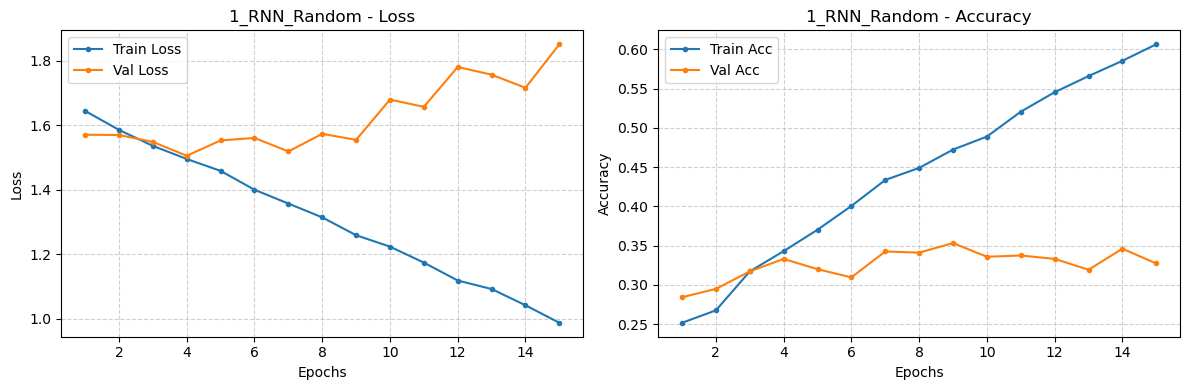

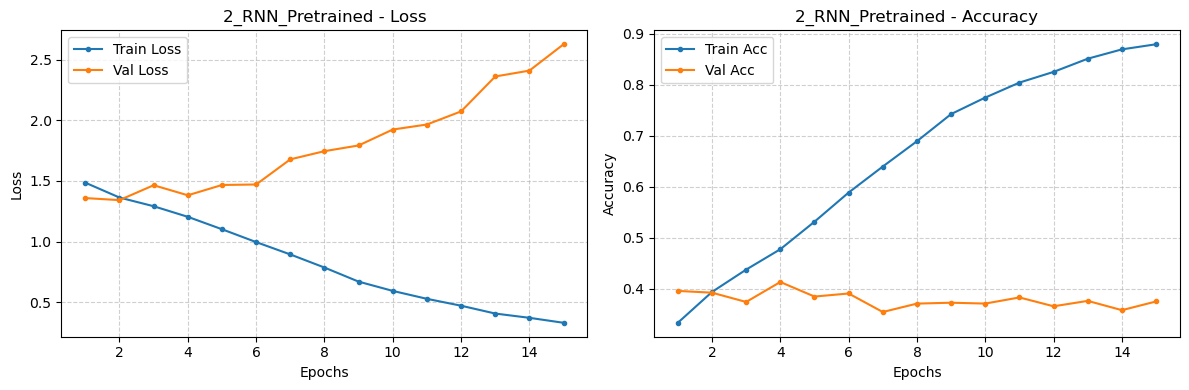

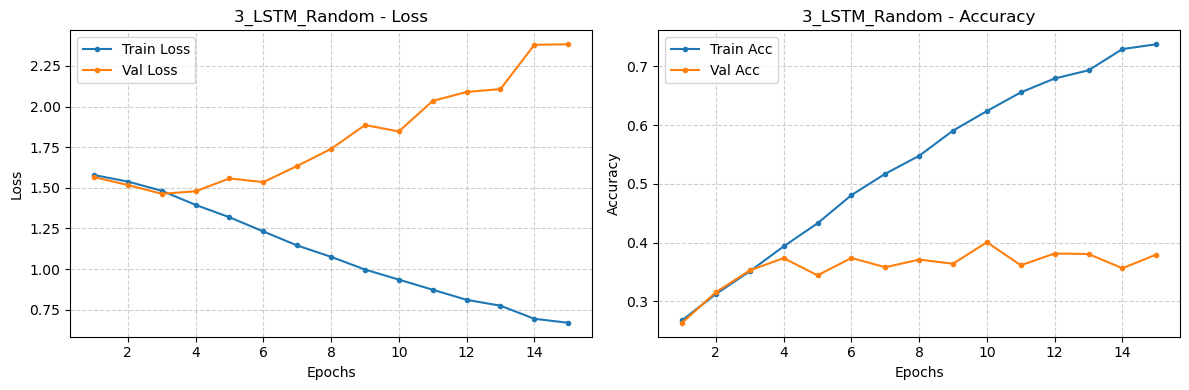

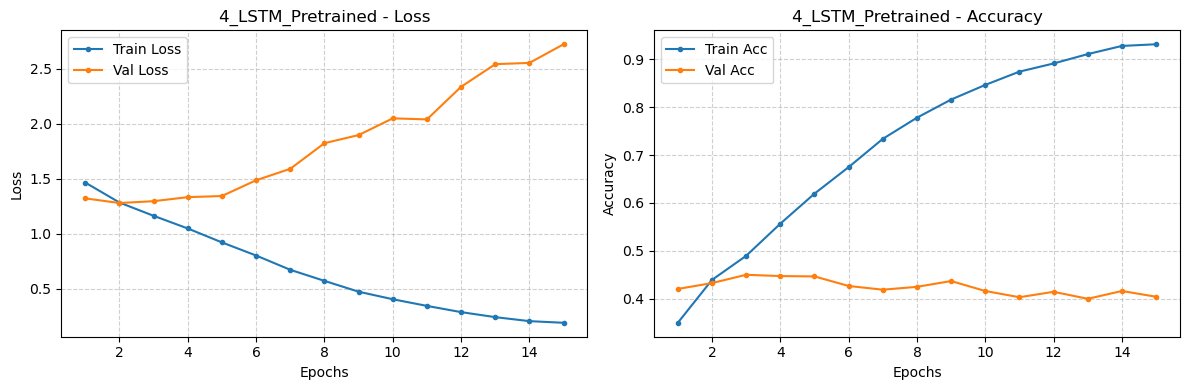

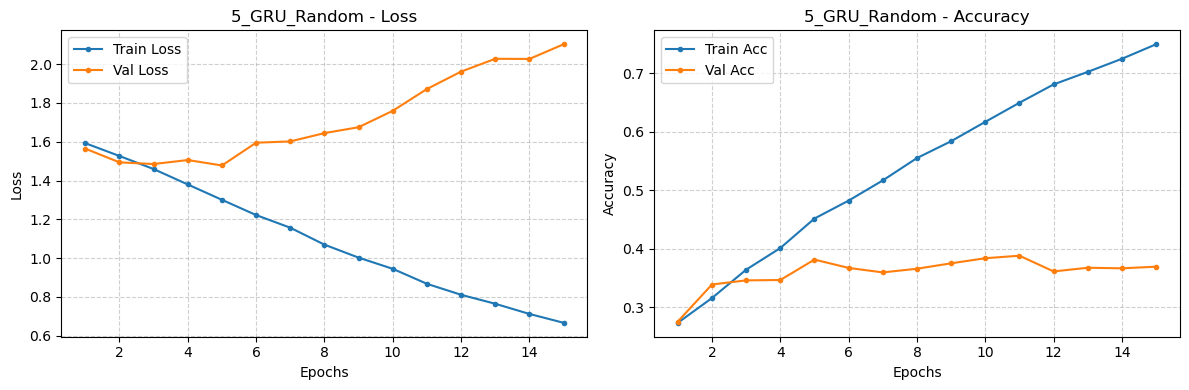

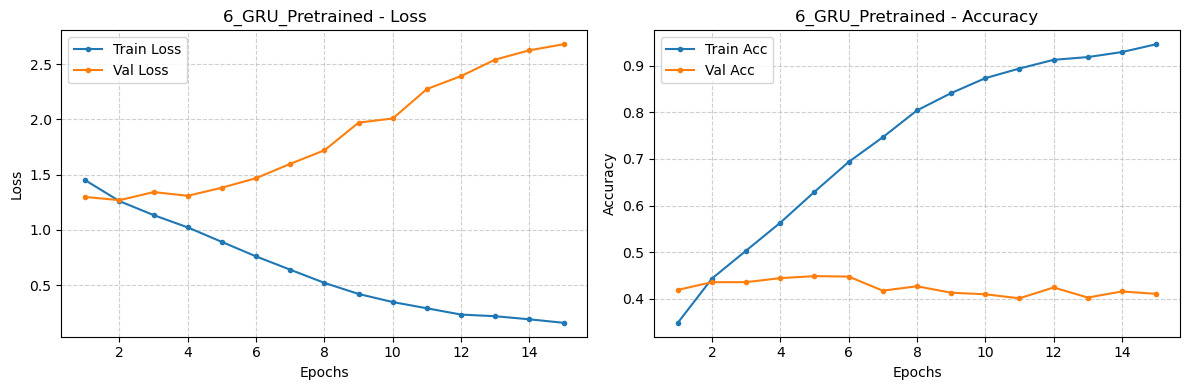

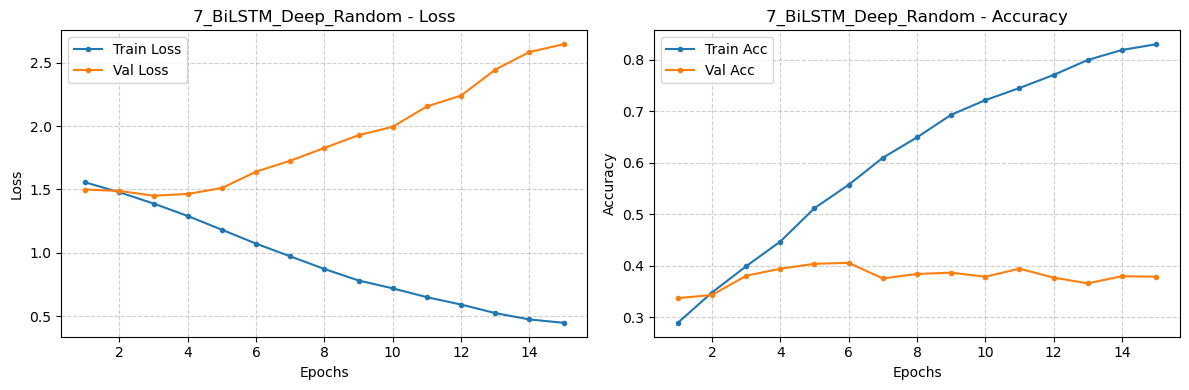

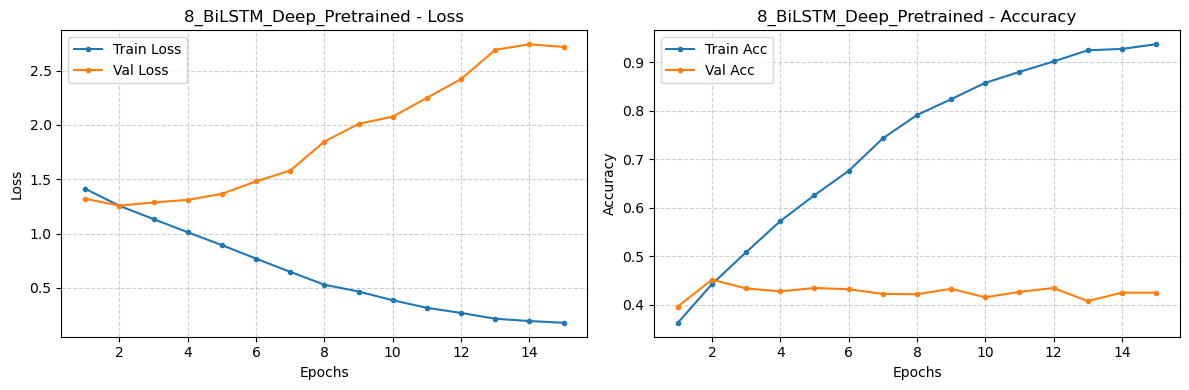

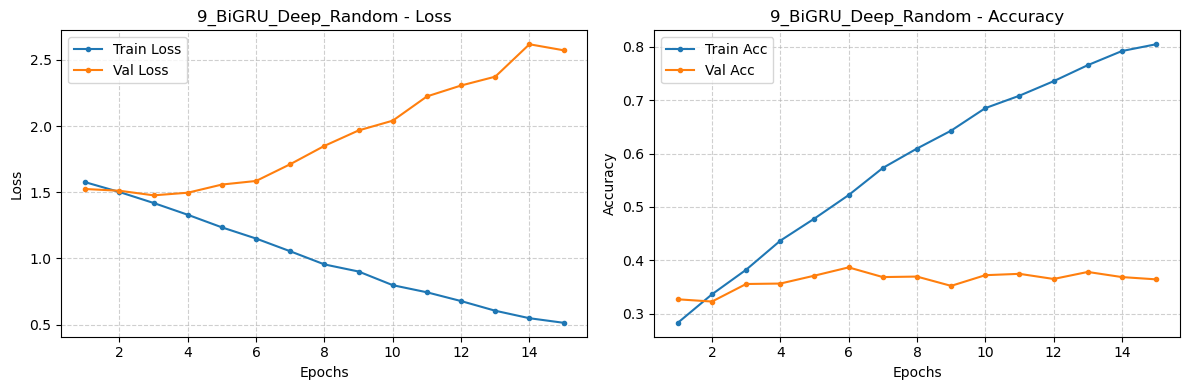

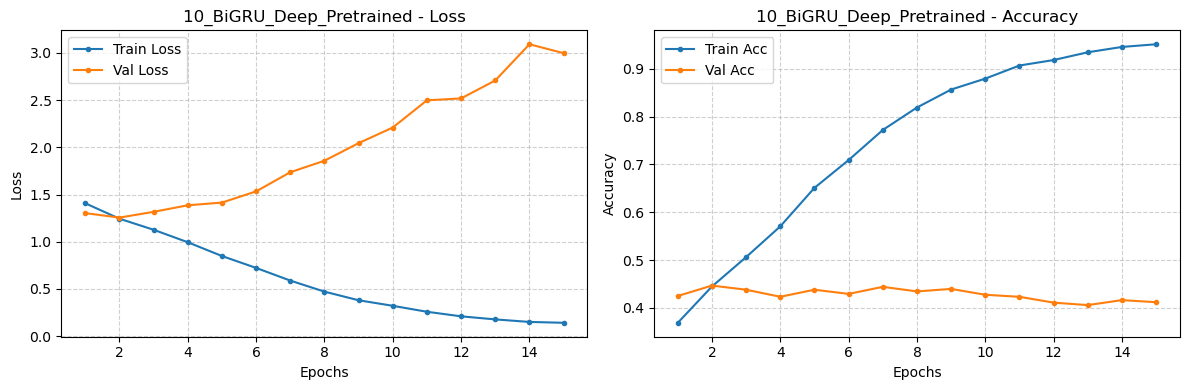

In [6]:
print(f"Generating plots for {len(all_histories)} models...\n")

for model_name, history in all_histories.items():
    Plotter.plot_history(history, title=model_name)

In [7]:
df_results = pd.DataFrame(all_summaries)

cols = [
    "Model",
    "Type",
    "BiDir",
    "Embeds",
    "Best Val Acc",
    "Best Val Loss",
    "Time (s)",
    "Parameters",
]
cols = [c for c in cols if c in df_results.columns]
df_results = df_results[cols + [c for c in df_results.columns if c not in cols]]

display(df_results.sort_values(by="Best Val Acc", ascending=False))

csv_path = os.path.join(CSV_DIR, "sst_experiment_results.csv")
df_results.to_csv(csv_path, index=False)
print(f"Results saved to {csv_path}")

,Model,Type,BiDir,Embeds,Best Val Acc,Best Val Loss,Time (s),Parameters,Layers,Train Loss,Train Acc,Val Loss,Val Acc
7,8_BiLSTM_Deep_Pretrained,LSTM,True,Pretrained,0.4517,1.2576,47.31,8206309,2,0.1796,0.9373,2.7180,0.4249
3,4_LSTM_Pretrained,LSTM,False,Pretrained,0.4501,1.2798,19.91,6056677,1,0.1914,0.9313,2.7227,0.4042
5,6_GRU_Pretrained,GRU,False,Pretrained,0.4483,1.2692,19.64,5913829,1,0.1588,0.9465,2.6806,0.4103
9,10_BiGRU_Deep_Pretrained,GRU,True,Pretrained,0.4466,1.2557,47.96,7526373,2,0.1413,0.9510,2.9977,0.4119
1,2_RNN_Pretrained,RNN,False,Pretrained,0.4129,1.3425,16.51,5628133,1,0.3327,0.8794,2.6255,0.3747
6,7_BiLSTM_Deep_Random,LSTM,True,Random,0.4058,1.4512,49.69,8206309,2,0.4496,0.8303,2.6444,0.3789
2,3_LSTM_Random,LSTM,False,Random,0.4008,1.4633,19.97,6056677,1,0.6692,0.7375,2.3836,0.3799
4,5_GRU_Random,GRU,False,Random,0.3884,1.4775,19.73,5913829,1,0.6667,0.7500,2.1021,0.3696
8,9_BiGRU_Deep_Random,GRU,True,Random,0.3868,1.4763,48.09,7526373,2,0.5135,0.8050,2.5722,0.3643
0,1_RNN_Random,RNN,False,Random,0.3532,1.5050,18.26,5628133,1,0.9867,0.6066,1.8509,0.3273


Results saved to ./csv_logs/sst_experiment_results.csv


## How can we improve our model?

In [ ]:
phase3_experiments = [
    {
        "name": "Baseline_Winner",
        "rnn_type": "lstm",
        "n_layers": 2,
        "bidirectional": True,
        "use_pretrained": True,
        "use_attention": False,
        "freeze_embeddings": True,
    },
    {
        "name": "FineTuned_Embeddings",
        "rnn_type": "lstm",
        "n_layers": 2,
        "bidirectional": True,
        "use_pretrained": True,
        "use_attention": False,
        "freeze_embeddings": False,
    },
    {
        "name": "Attention_Frozen",
        "rnn_type": "lstm",
        "n_layers": 2,
        "bidirectional": True,
        "use_pretrained": True,
        "use_attention": True,
        "freeze_embeddings": True,
    },
    {
        "name": "Best_Model_Full_Opt",
        "rnn_type": "lstm",
        "n_layers": 2,
        "bidirectional": True,
        "use_pretrained": True,
        "use_attention": True,
        "freeze_embeddings": False,
    },
]

In [ ]:
all_histories = {}
all_summaries = []

for config in phase3_experiments:
    print(f"\n{'='*20} Running: {config['name']} {'='*20}")

    model = DynamicRNN(
        vocab_size=VOCAB_SIZE,
        embedding_dim=EMBEDDING_DIM,
        hidden_dim=HIDDEN_DIM,
        output_dim=OUTPUT_DIM,
        n_layers=config["n_layers"],
        bidirectional=config["bidirectional"],
        dropout=DROPOUT,
        pad_idx=PAD_IDX,
        rnn_type=config["rnn_type"],
        use_attention=False,
        freeze_embeddings=True,
    )

    if config["use_pretrained"]:
        if PRETRAINED_VECTORS is not None:
            print(f"Loading vectors...")
            model.embedding.weight.data.copy_(PRETRAINED_VECTORS)
        else:
            print("Vectors not found, using random.")

    hyperparams = {
        "Type": config["rnn_type"].upper(),
        "BiDir": config["bidirectional"],
        "Embeds": "Pretrained" if config["use_pretrained"] else "Random",
        "Layers": config["n_layers"],
    }

    trainer = Trainer(model, DEVICE)
    history, summary = trainer.run_experiment(
        train_iter,
        val_iter,
        epochs=EPOCHS,
        lr=LEARNING_RATE,
        name=config["name"],
        hyperparameters=hyperparams,
        save_weights=True,
    )

    all_histories[config["name"]] = history
    all_summaries.append(summary)

print("\nAll models trained successfully.")


==================== Running: Baseline_Winner ====================
Loading vectors...
Starting Baseline_Winner | Params: 2,722,309


  Epoch: 01 | Time: 0m 2s | Train Acc: 0.362 | Val Acc: 0.405
  Epoch: 02 | Time: 0m 2s | Train Acc: 0.418 | Val Acc: 0.403
  Epoch: 03 | Time: 0m 2s | Train Acc: 0.437 | Val Acc: 0.447
  Epoch: 04 | Time: 0m 3s | Train Acc: 0.455 | Val Acc: 0.460
  Epoch: 05 | Time: 0m 2s | Train Acc: 0.473 | Val Acc: 0.466
  Epoch: 06 | Time: 0m 2s | Train Acc: 0.486 | Val Acc: 0.450
  Epoch: 07 | Time: 0m 2s | Train Acc: 0.506 | Val Acc: 0.466
  Epoch: 08 | Time: 0m 2s | Train Acc: 0.521 | Val Acc: 0.466
  Epoch: 09 | Time: 0m 2s | Train Acc: 0.536 | Val Acc: 0.449
  Epoch: 10 | Time: 0m 2s | Train Acc: 0.566 | Val Acc: 0.440
  Epoch: 11 | Time: 0m 2s | Train Acc: 0.578 | Val Acc: 0.449
  Epoch: 12 | Time: 0m 2s | Train Acc: 0.605 | Val Acc: 0.440
  Epoch: 13 | Time: 0m 2s | Train Acc: 0.635 | Val Acc: 0.432
  Epoch: 14 | Time: 0m 2s | Train Acc: 0.657 | Val Acc: 0.428
  Epoch: 15 | Time: 0m 2s | Train Acc: 0.682 | Val Acc: 0.448
Experiement Complete with Train Accuracy: 0.6821, Val Accuracy: 0.4482

Generating plots for 4 models...



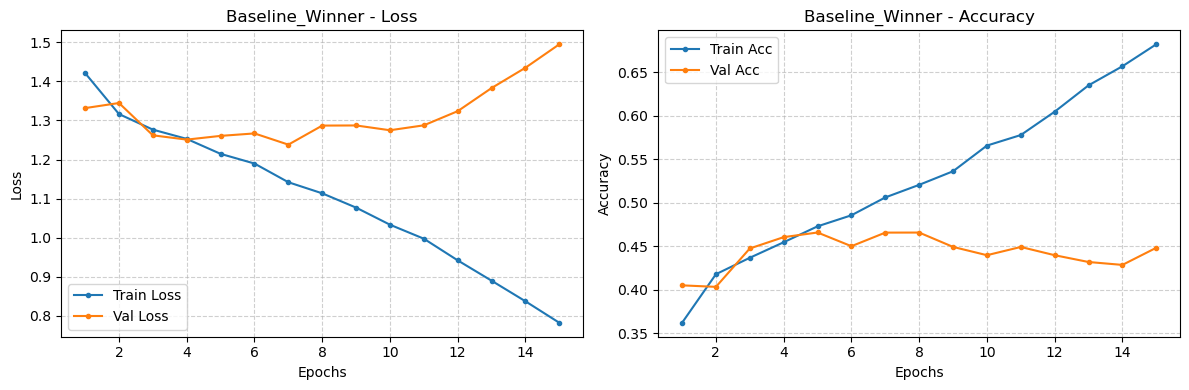

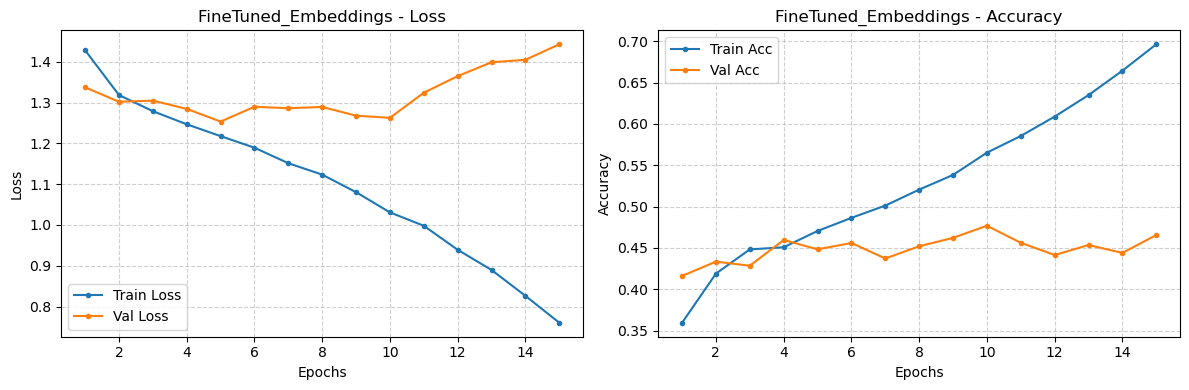

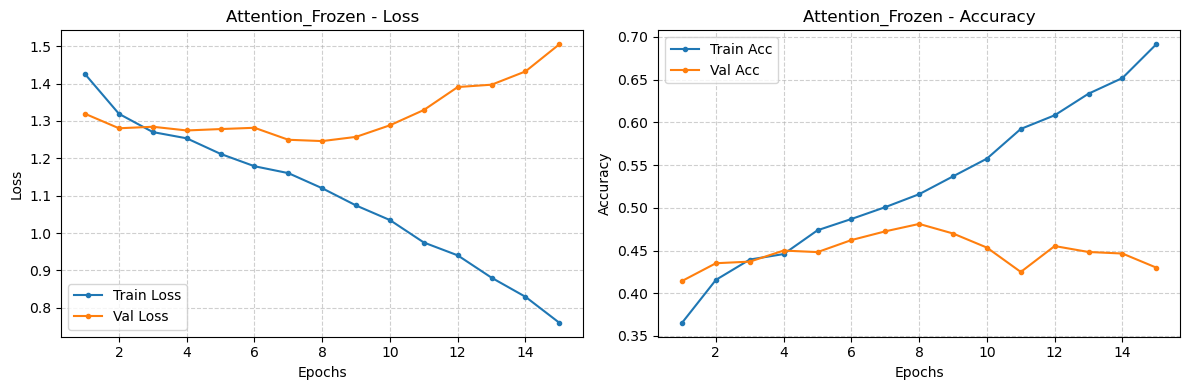

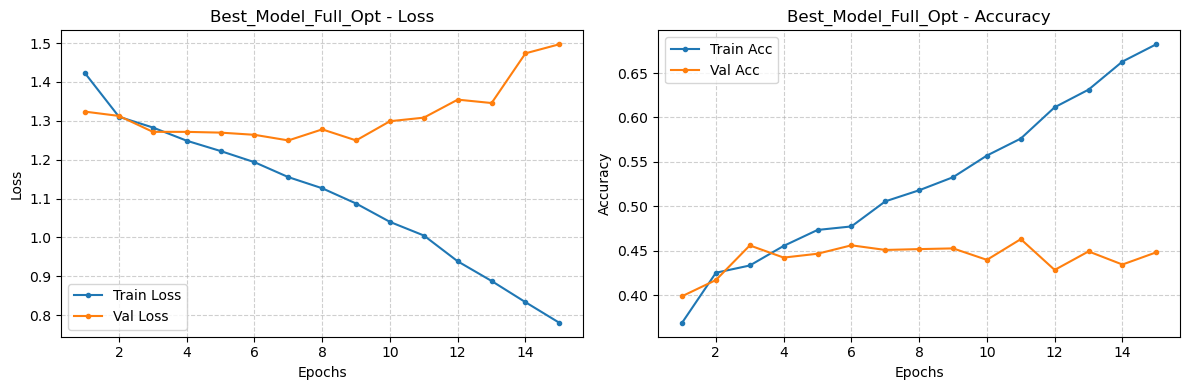

In [ ]:
print(f"Generating plots for {len(all_histories)} models...\n")

for model_name, history in all_histories.items():
    Plotter.plot_history(history, title=model_name)

In [ ]:
df_results = pd.DataFrame(all_summaries)

cols = [
    "Model",
    "Type",
    "BiDir",
    "Embeds",
    "Best Val Acc",
    "Best Val Loss",
    "Time (s)",
    "Parameters",
]

cols = [c for c in cols if c in df_results.columns]
df_results = df_results[cols + [c for c in df_results.columns if c not in cols]]

print("\n--- Experiment Leaderboard (Sorted by Validation Accuracy) ---")
display(df_results.sort_values(by="Best Val Acc", ascending=False))

csv_path = os.path.join(CSV_DIR, "sst_phase3_results.csv")
df_results.to_csv(csv_path, index=False)
print(f"Results saved to {csv_path}")


--- Experiment Leaderboard (Sorted by Validation Accuracy) ---


,Model,Type,BiDir,Embeds,Best Val Acc,Best Val Loss,Time (s),Parameters,Layers,Train Loss,Train Acc,Val Loss,Val Acc
2,Attention_Frozen,LSTM,True,Pretrained,0.4812,1.2461,33.72,2722309,2,0.7601,0.6915,1.5050,0.4300
1,FineTuned_Embeddings,LSTM,True,Pretrained,0.4768,1.2535,33.70,2722309,2,0.7601,0.6962,1.4431,0.4656
0,Baseline_Winner,LSTM,True,Pretrained,0.4657,1.2381,32.55,2722309,2,0.7820,0.6821,1.4951,0.4482
3,Best_Model_Full_Opt,LSTM,True,Pretrained,0.4631,1.2495,37.22,2722309,2,0.7804,0.6824,1.4968,0.4483


Results saved to ./csv_logs/sst_phase3_results.csv


#### Our Attention Frozen model performs the best. Let's do some hyperparameter tuning!

In [ ]:
param_grid = {
    "lr": [1e-3, 5e-4],
    "hidden_dim": [128, 256],
    "dropout": [0.5, 0.65],
    "n_layers": [1, 2],
}


keys, values = zip(*param_grid.items())
combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

print(f"Total experiments to run: {len(combinations)}")


best_acc = 0.0
best_config = None
best_model_path = os.path.join(TRAINED_WEIGHTS_DIR, "best_tuning_model.pt")


for i, config in enumerate(combinations):
    print(f"\n--- Running Config {i+1}/{len(combinations)}: {config} ---")

    model = DynamicRNN(
        vocab_size=VOCAB_SIZE,
        embedding_dim=EMBEDDING_DIM,
        hidden_dim=config["hidden_dim"],
        output_dim=OUTPUT_DIM,
        n_layers=config["n_layers"],
        bidirectional=True,
        dropout=config["dropout"],
        pad_idx=PAD_IDX,
        rnn_type="lstm",
        use_attention=True,
    )

    model.embedding.weight.data.copy_(PRETRAINED_VECTORS)
    model.embedding.weight.requires_grad = False

    trainer = Trainer(model, DEVICE)
    history, summary = trainer.run_experiment(
        train_iter,
        val_iter,
        epochs=15,
        lr=config["lr"],
        name=f"Tuning_{i}",
        hyperparameters=config,
        save_weights=False,
    )

    val_acc = summary["Best Val Acc"]

    if val_acc > best_acc:
        best_acc = val_acc
        best_config = config

        torch.save(model.state_dict(), best_model_path)

        print(f"!!! New Champion! Acc: {best_acc:.4f} | Saved to {best_model_path} !!!")

print(f"\nSearch Complete.")
print(f"Best Config: {best_config}")
print(f"Best Accuracy: {best_acc}")

Total experiments to run: 16

--- Running Config 1/16: {'lr': 0.001, 'hidden_dim': 128, 'dropout': 0.5, 'n_layers': 1} ---
Starting Tuning_0 | Params: 458,118
  Epoch: 01 | Time: 0m 3s | Train Acc: 0.360 | Val Acc: 0.394
  Epoch: 02 | Time: 0m 3s | Train Acc: 0.426 | Val Acc: 0.409
  Epoch: 03 | Time: 0m 3s | Train Acc: 0.441 | Val Acc: 0.429
  Epoch: 04 | Time: 0m 3s | Train Acc: 0.459 | Val Acc: 0.448
  Epoch: 05 | Time: 0m 1s | Train Acc: 0.471 | Val Acc: 0.442
  Epoch: 06 | Time: 0m 2s | Train Acc: 0.478 | Val Acc: 0.444
  Epoch: 07 | Time: 0m 1s | Train Acc: 0.490 | Val Acc: 0.469
  Epoch: 08 | Time: 0m 1s | Train Acc: 0.505 | Val Acc: 0.472
  Epoch: 09 | Time: 0m 1s | Train Acc: 0.507 | Val Acc: 0.463
  Epoch: 10 | Time: 0m 1s | Train Acc: 0.516 | Val Acc: 0.486
  Epoch: 11 | Time: 0m 2s | Train Acc: 0.530 | Val Acc: 0.456
  Epoch: 12 | Time: 0m 1s | Train Acc: 0.539 | Val Acc: 0.451
  Epoch: 13 | Time: 0m 1s | Train Acc: 0.553 | Val Acc: 0.477
  Epoch: 14 | Time: 0m 1s | Train A

In [ ]:
df_results = pd.DataFrame(all_summaries)

cols_ordered = [
    "Model",
    "Type",
    "BiDir",
    "Embeds",
    "Layers",
    "hidden_dim",
    "dropout",
    "lr",
    "Best Val Acc",
    "Best Val Loss",
    "Time (s)",
    "Parameters",
]

cols = [c for c in cols_ordered if c in df_results.columns]
remaining_cols = [c for c in df_results.columns if c not in cols]
df_results = df_results[cols + remaining_cols]

print("\n--- Experiment Leaderboard (Sorted by Validation Accuracy) ---")
display(df_results.sort_values(by="Best Val Acc", ascending=False))

csv_path = os.path.join(CSV_DIR, "sst_final_results.csv")
df_results.to_csv(csv_path, index=False)
print(f"Results saved to {csv_path}")


--- Experiment Leaderboard (Sorted by Validation Accuracy) ---


,Model,Type,BiDir,Embeds,Layers,Best Val Acc,Best Val Loss,Time (s),Parameters,Train Loss,Train Acc,Val Loss,Val Acc
2,Attention_Frozen,LSTM,True,Pretrained,2,0.4812,1.2461,33.72,2722309,0.7601,0.6915,1.5050,0.4300
1,FineTuned_Embeddings,LSTM,True,Pretrained,2,0.4768,1.2535,33.70,2722309,0.7601,0.6962,1.4431,0.4656
0,Baseline_Winner,LSTM,True,Pretrained,2,0.4657,1.2381,32.55,2722309,0.7820,0.6821,1.4951,0.4482
3,Best_Model_Full_Opt,LSTM,True,Pretrained,2,0.4631,1.2495,37.22,2722309,0.7804,0.6824,1.4968,0.4483


Results saved to ./csv_logs/sst_final_results.csv


### test out the final model!

In [ ]:
print(f"{'='*40}")
print(f"TESTING BEST MODEL (From Tuning)")
print(f"Best Config: {best_config}")
print(f"Validation Acc: {best_acc:.4f}")
print(f"{'='*40}")

test_model = DynamicRNN(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=best_config["hidden_dim"],
    output_dim=OUTPUT_DIM,
    n_layers=best_config["n_layers"],
    bidirectional=True,
    dropout=best_config["dropout"],
    pad_idx=PAD_IDX,
    rnn_type="lstm",
    use_attention=True,
)

if os.path.exists(best_model_path):
    print(f"--> Loading weights from: {best_model_path}")
    test_model.load_state_dict(torch.load(best_model_path, map_location=DEVICE))
else:
    raise FileNotFoundError(f"Could not find weights file: {best_model_path}")

final_trainer = Trainer(test_model, DEVICE)
test_loss, test_acc = final_trainer.evaluate_model(test_iter)

print(f"\n{'='*30}")
print(f"FINAL TEST RESULTS")
print(f"{'='*30}")
print(f"Test Loss:     {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"{'='*30}")

TESTING BEST MODEL (From Tuning)
Best Config: {'lr': 0.001, 'hidden_dim': 128, 'dropout': 0.65, 'n_layers': 2}
Validation Acc: 0.4890
--> Loading weights from: ./trained_weights/best_tuning_model.pt

FINAL TEST RESULTS
Test Loss:     1.1774
Test Accuracy: 0.4667 (46.67%)
